# The Time for Crime

## Members
- Kavya Ramamoorthy A13674296
- Lakshmi S Menon A13308675
- Quang Do A13500965
- Rohan Patel A13563184

## Introduction and Background
A lot of interesting analyses have been carried out on police and crime data. Quite often, analyses are done to find correlations between race and likelihood of being stopped by police, and strong evidence of racial bias has been found in many cases. We wanted to approach the issue in a different manner, looking at whether time of day had any effect on likelihood of being pulled over by a police officer. We found only one related study that has been done involving time of the police pullover. This study was still looking for evidence of racial profiling, but examined it from the point of view of time of the stop. The study compared the stop rates of non-white drivers during times of daylight and darkness, to see whether visibility of the driver, and hence ability to racially profile them, had an effect on likelihood of being stopped. 

Reference: http://hup.umn.edu/docs/DetectingRacialProfiling.pdf

For our analysis, we wanted to look into whether time of day had an effect on likelihood of being searched by police. Nuilding off this, we wanted to see whether this effect was correlated with the factors of gender and race. We hypothesize that the likelihood of being searched is different at different times of day. In particular, we expect more people to be searched after dark, which we approximate to be between the hours of 8pm and 6am, i.e. 2000 hours and 0600 hours. We also expect to see a disparity between races and genders. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm

C:\Users\lakim\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Description

We sourced our dataset from the Data SD website, at https://data.sandiego.gov/datasets/police-vehicle-stops/ .
We used the Police Vehicle Stops dataset. It contains a record of all the vehicle stops for a given year. Data was available for the years 2014-2017, and we used all sets in our analysis. Before cleaning, the 2016 dataset had 103,051 entries, the 2015 set had 115,422, and the 2014 set had 144,164. The 2017 dataset includes information only upto (and including) March 31, 2017, so it had a total of 28,362 entries. 



In [2]:
#import our raw data and merging it into one file
df1 = pd.read_csv('stops_2014.csv')
print("df1: ", df1.shape)
df2 = pd.read_csv('stops_2015.csv')
print("df2: ", df2.shape)
df3 = pd.read_csv('stops_2016.csv')
print("df3: ", df3.shape)
df4 = pd.read_csv('stops_2017.csv')
print("df4: ", df4.shape)

frames = [df1,df2,df3,df4]
df = pd.concat(frames)
print("final df: ", df.shape)

df1:  (144164, 15)
df2:  (115422, 15)
df3:  (103051, 15)
df4:  (28362, 17)
final df:  (390999, 17)


Each dataset includes a variety of information about the police stops, including the exact date and time the stop took place, gender age, and race of the subject, and information such as whether the subject was searched or arrested, and if contraband was found. 

## Data Cleaning/Pre-processing

Before we carried out our data analysis, we had to clean up our data set to take out any unnecessary or invalid data to make our analysis methods effective. We began by capitalizing the string values so that they would be more uniform. 

For our research question, we wanted to focus only on gender, race, and time of day that the stop occurred, so we dropped the other columns. We dropped columns such as whether the stopped person was a San Diego resident, their age, the police service area in which the stop took place, as well as whether contraband was found and whether consent was given for the search. Ultimately, we were left with the following columns, on which we planned to carry out our analysis:
 - searched
 - stop_cause
 - stop_date
 - stop_time
 - subject_race
 - subject_sex
 
 From the remaining columns, we dropped any rows which had NaN values, as these would not be useful for our analysis. We also converted the entries in the time column into military time so that it would be easier to work with as there is a clear order from 0000 to 2359 hrs. This also makes it easier for us to sort, compare, or do perform other operations on the data, as we don't have to have a separate distinction between AM and PM. 

In [3]:
#Dropping unnecessary columns
df.drop(['Unnamed: 15','Unnamed: 16','contraband_found','obtained_consent','property_seized','sd_resident','service_area','stop_id','subject_age','timestamp','arrested'], axis = 1, inplace = True)
#Dropping rows with NaN values
df.dropna(subset = ['stop_time','subject_race','subject_sex','searched','stop_time'], inplace = True)

#Converting stop time to military time
df['stop_time'] = df.loc[:, 'stop_time'].replace(regex=True, to_replace=":", value="")
df["stop_time"] = pd.to_numeric(df['stop_time'], errors = 'coerce', downcast = 'integer')

#Some entries had invalid decimal values as time. To include these, we took all the entries with time=0 (i.e. midnight) and all
#the entries with time between 00:01 and 23:59 and combined the two sets
df5 = df[df['stop_time'] == 0]
df = df[df['stop_time'] < 2400]
df = df[df['stop_time'] >= 1]
df = pd.concat([df5,df])
df.sort_values(by = 'stop_time', ascending = True ,inplace = True)
df['stop_time'] = df['stop_time'].astype(np.int64)

#write function to handle lowercase
def make_uppercase(string):
    if string == "y":
        return string.upper()
    elif string == "n":
        return string.upper()
    elif string == "Y": 
        return string
    elif string == "N":
        return string
    else:
        return "N/A"

df['searched'] = df['searched'].apply(make_uppercase)
df = df[df['searched'] != "N/A"]
df['searched'].value_counts()

def make_boolean(string):
    if string == "Y":
        return 1
    if string == "N":
        return 0
df['searched'] = df['searched'].apply(make_boolean)

#Output final dataframe
df

,searched,stop_cause,stop_date,stop_time,subject_race,subject_sex
119,0,Equipment Violation,2014-01-03,0,B,M
87379,0,Moving Violation,2015-09-29,0,H,F
87378,0,Moving Violation,2015-09-29,0,O,F
87207,0,Equipment Violation,2015-09-28,0,O,M
87076,0,Moving Violation,2015-09-27,0,S,M
86398,0,Moving Violation,2015-09-24,0,A,M
85238,0,Equipment Violation,2015-09-19,0,H,M
85237,0,Moving Violation,2015-09-19,0,W,M
84953,0,Moving Violation,2015-09-18,0,B,M
84585,1,Moving Violation,2015-09-17,0,W,M


## Data Visualization

For graphing, we decided to graph the frequency rather than the total count to avoid any discrepancies due to larger number of people in the sample size

In [4]:
df['subject_sex'].value_counts()

M    228529
F    123902
X        47
Name: subject_sex, dtype: int64

In [5]:
#Finding frequency of people searched, given that they have been stopped - by gender
total_males = df['subject_sex'].value_counts()[0]
males_searched = df[df['subject_sex'] == "M"]['searched'].value_counts()[1]

freq_search_m = males_searched/total_males
print("Frequency of Males Searched: ",freq_search_m)

total_females = df['subject_sex'].value_counts()[1]
females_searched = df[df['subject_sex'] == "F"]['searched'].value_counts()[1]

freq_search_f = females_searched/total_females
print("Frequency of Females Searched: ",freq_search_f)

Frequency of Males Searched:  0.0589859492668
Frequency of Females Searched:  0.0261254862714


In [6]:
#Manual inspection of X elements shows that there are only 47, and none have been searched
X_entries = df[df['subject_sex'] == "X"]
X_entries

,searched,stop_cause,stop_date,stop_time,subject_race,subject_sex
56050,0,Equipment Violation,2014-05-02,10,O,X
50744,0,Equipment Violation,2015-05-31,11,H,X
89650,0,Equipment Violation,2015-10-07,15,O,X
142575,0,Moving Violation,2014-12-26,25,W,X
142574,0,Moving Violation,2014-12-26,25,W,X
55345,0,Equipment Violation,2015-06-14,38,W,X
3167,0,"Muni, County, H&S Code",2014-01-16,200,O,X
1214,0,Radio Call/Citizen Contact,1/5/17,225,O,X
44648,0,Equipment Violation,2014-04-08,235,W,X
102957,0,Radio Call/Citizen Contact,2015-11-19,258,X,X


In [7]:
#Set frequency of gender X being searched to 0 as there were a negligible number of X people (47), and none of them had been searched.
freq_search_x = 0

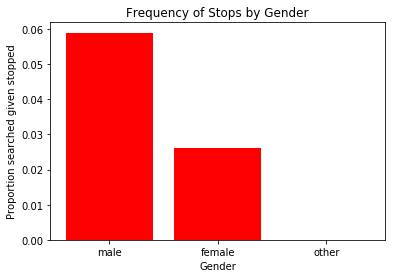

In [8]:
#Plotting the proportion of each gender that is searched given that they are stopped.
gender_data = {'male':freq_search_m, 'female':freq_search_f, 'other':freq_search_x}
gender_names = list(gender_data.keys())
gender_values = list(gender_data.values())

index2 = np.arange(len(gender_names))
plt.bar(index2, gender_values, color = 'r')
plt.xlabel('Gender')
plt.ylabel('Proportion searched given stopped')
plt.xticks(index2, gender_names, rotation= 'horizontal')
plt.title('Frequency of Stops by Gender')
plt.show()

In [9]:
#Counts of each race
print (df['subject_race'].value_counts())


W    151642
H    105019
B     39956
O     24796
A     16303
F      4972
V      2803
C      2025
I      1843
X       598
K       538
J       464
P       373
Z       306
L       280
S       207
D       194
G       103
U        56
Name: subject_race, dtype: int64


In [10]:
#The race codes were given in a separate file on the website
df_race = pd.read_csv('vehicle_stops_race_codes.csv')
print(df_race)

   Race Code       Description
0          A       OTHER ASIAN
1          B             BLACK
2          C           CHINESE
3          D         CAMBODIAN
4          F          FILIPINO
5          G         GUAMANIAN
6          H          HISPANIC
7          I            INDIAN
8          J          JAPANESE
9          K            KOREAN
10         L           LAOTIAN
11         O             OTHER
12         P  PACIFIC ISLANDER
13         S            SAMOAN
14         U          HAWAIIAN
15         V        VIETNAMESE
16         W             WHITE
17         Z      ASIAN INDIAN


In [11]:
#GRAPHING THE DATA, FOR RACE
total_White = df['subject_race'].value_counts()[0]
White_searched = df[df['subject_race'] == "W"]['searched'].value_counts()[1]

freq_search_W = White_searched/total_White
print ("Frequency of White Searched: ", freq_search_W)

total_Hispanic = df['subject_race'].value_counts()[1]
Hispanic_searched = df[df['subject_race'] == "H"]['searched'].value_counts()[1]

freq_search_H = Hispanic_searched/total_Hispanic
print ("Frequency of Hispanic Searched: ", freq_search_H)

total_Black = df['subject_race'].value_counts()[2]
Black_searched = df[df['subject_race'] == "B"]['searched'].value_counts()[1]

freq_search_B = Black_searched/total_Black
print ("Frequency of Black Searched: ", freq_search_B)

total_Other = df['subject_race'].value_counts()[3]
Other_searched = df[df['subject_race'] == "O"]['searched'].value_counts()[1]

freq_search_O = Other_searched/total_Other
print ("Frequency of Other Searched: ", freq_search_O)

total_OtherAsian = df['subject_race'].value_counts()[4]
OtherAsian_searched = df[df['subject_race'] == "A"]['searched'].value_counts()[1]

freq_search_A = OtherAsian_searched/total_OtherAsian
print ("Frequency of Other Asian Searched: ", freq_search_A)

total_Filipino = df['subject_race'].value_counts()[5]
Filipino_searched = df[df['subject_race'] == "F"]['searched'].value_counts()[1]

freq_search_F = Filipino_searched/total_Filipino
print ("Frequency of Filipino Searched: ", freq_search_F)

total_Vietnamese = df['subject_race'].value_counts()[6]
Vietnamese_searched = df[df['subject_race'] == "V"]['searched'].value_counts()[1]

freq_search_V = Vietnamese_searched/total_Vietnamese
print ("Frequency of Vietnamese Searched: ", freq_search_V)

total_Chinese = df['subject_race'].value_counts()[7]
Chinese_searched = df[df['subject_race'] == "C"]['searched'].value_counts()[1]

freq_search_C = Chinese_searched/total_Chinese
print ("Frequency of Chinese Searched: ", freq_search_C)

total_Indian = df['subject_race'].value_counts()[8]
Indian_searched = df[df['subject_race'] == "I"]['searched'].value_counts()[1]

freq_search_I = Indian_searched/total_Indian
print ("Frequency of Indian Searched: ", freq_search_I)

total_Korean = df['subject_race'].value_counts()[10]
Korean_searched = df[df['subject_race'] == "K"]['searched'].value_counts()[1]

freq_search_K = Korean_searched/total_Korean
print ("Frequency of Korean Searched: ", freq_search_K)


Frequency of White Searched:  0.0306445443874
Frequency of Hispanic Searched:  0.0635980155972
Frequency of Black Searched:  0.0998348183001
Frequency of Other Searched:  0.0187933537667
Frequency of Other Asian Searched:  0.0209777341594
Frequency of Filipino Searched:  0.0343925985519
Frequency of Vietnamese Searched:  0.0599357830895
Frequency of Chinese Searched:  0.0143209876543
Frequency of Indian Searched:  0.0238741182854
Frequency of Korean Searched:  0.0371747211896


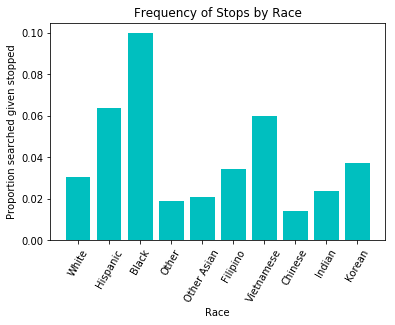

In [12]:
race_data = {'White':freq_search_W, 'Hispanic':freq_search_H, 'Black':freq_search_B, 'Other':freq_search_O, 
        'Other Asian':freq_search_A, 'Filipino':freq_search_F, 'Vietnamese':freq_search_V, 
        'Chinese':freq_search_C, 'Indian':freq_search_I, 'Korean':freq_search_K}
race_names = list(race_data.keys())
race_values = list(race_data.values())

index = np.arange(len(race_names))
plt.bar(index, race_values, color = 'c')
plt.xlabel('Race')
plt.ylabel('Proportion searched given stopped')
plt.xticks(index, race_names, rotation=60)
plt.title('Frequency of Stops by Race')
plt.show()


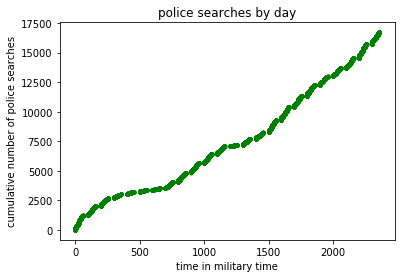

In [13]:
#cumulative stops

search_times = df[df['searched'] == 1]['stop_time']
y = np.arange(1,len(search_times)+1 / len(search_times))
plt.plot(search_times, y, marker = '.', linestyle = 'none', color = "g")
plt.xlabel("time in military time")
plt.ylabel("cumulative number of police searches")
plt.title("police searches by day")
plt.show()

As the cumulative stops is not a perfectly linear graph, we understand that there are times when there are more or less searches than normal.

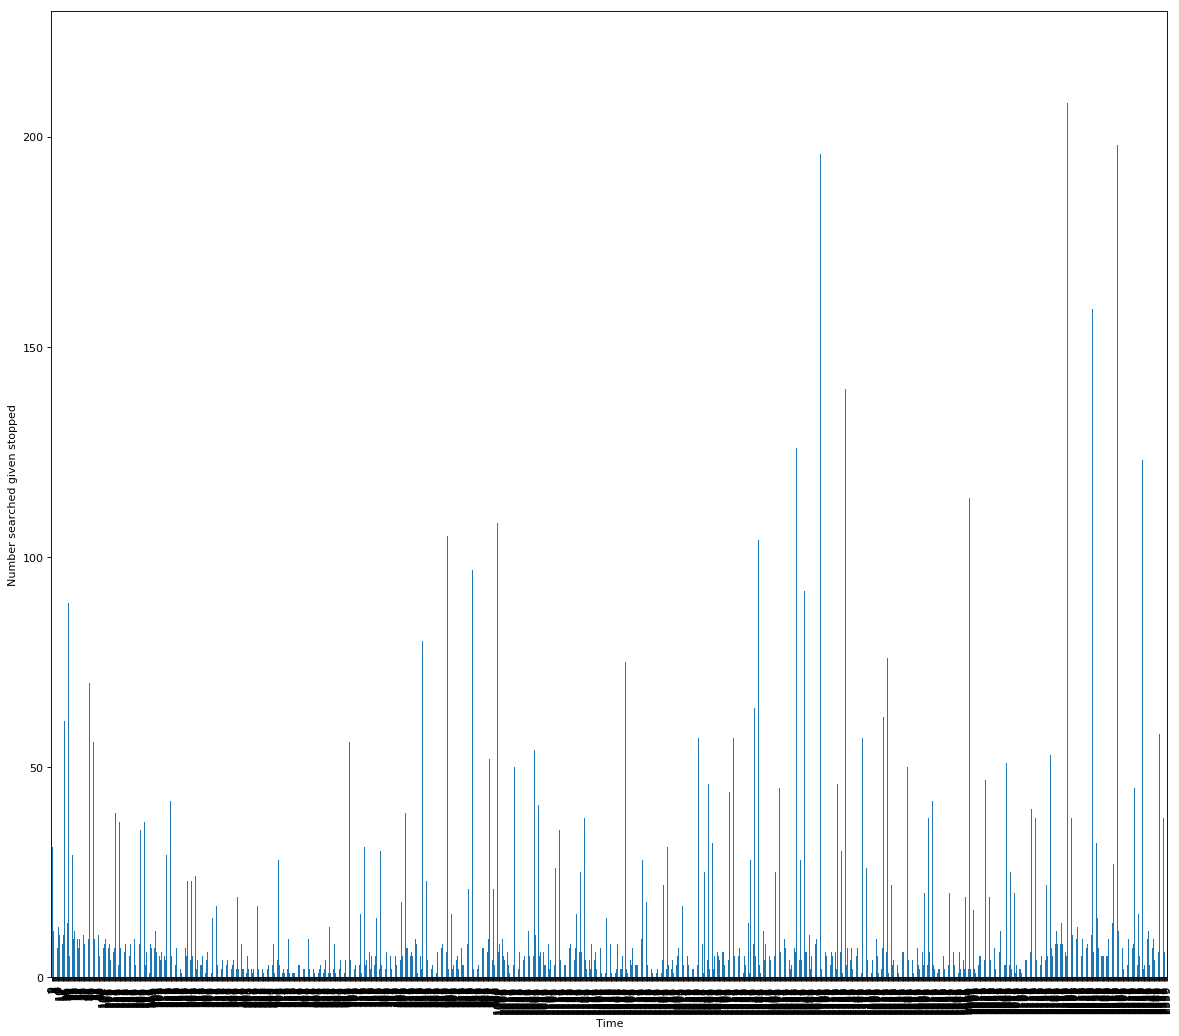

In [14]:
#Plot of number of searches at each time, i.e. each minute
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
numbers = search_times.value_counts(sort = False).sort_index()
numbers.plot(kind = 'bar')
plt.xlabel('Time')
plt.ylabel('Number searched given stopped')
plt.show()

#### To make our visualization clearer, we decided to group the stop times by each hour, and plot the total number of searched per hour.

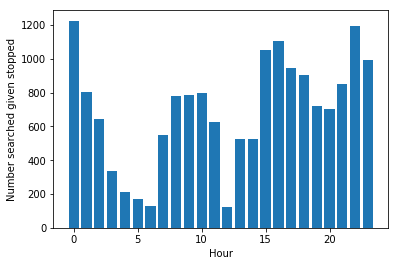

In [15]:
#To find the number of searches each hour (as opposed to each minute)
hours = numbers.index.values
search_per_hour = np.zeros((24), dtype = np.int)
for i in hours:
    time = int(i/100)
    search_per_hour[time] = search_per_hour[time]+numbers[i]
    
plt.bar(np.arange(len(search_per_hour)), search_per_hour)
plt.xlabel('Hour')
plt.ylabel('Number searched given stopped')
plt.show()

There appears to be clear peaks and dips at different times of the day. The majority of searches appear to be between 9pm and 5am, with another peak during rush hour times around 8-11 and 3-6. 

## Data Analysis and Results

In [16]:
#PREDICTING THE CORRELATION COEFFECIENTS OF THESE VARIABLES ON BEING SEARCHED
outcome_time, predictors_time = patsy.dmatrices('searched ~ stop_time', df)
mod_time = sm.OLS(outcome_time, predictors_time)
res_time = mod_time.fit()
print(res_time.summary())

res_time.pvalues[1]

                            OLS Regression Results                            
Dep. Variable:               searched   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     39.04
Date:                Wed, 21 Mar 2018   Prob (F-statistic):           4.17e-10
Time:                        13:34:47   Log-Likelihood:                 45714.
No. Observations:              352478   AIC:                        -9.142e+04
Df Residuals:                  352476   BIC:                        -9.140e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0429      0.001     52.726      0.0

4.166557744980443e-10

The p value in this case is 0 which is less than 0.05, implying a significant correlation between being searched and stop time. 

In [17]:
#PREDICTING THE CORRELATION COEFFECIENTS OF THESE VARIABLES ON BEING SEARCHED
outcome_race, predictors_race = patsy.dmatrices('searched ~ subject_race', df)
mod_race = sm.OLS(outcome_race, predictors_race)
res_race = mod_race.fit()
print(res_race.summary())
res_race.pvalues[1]

                            OLS Regression Results                            
Dep. Variable:               searched   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     285.2
Date:                Wed, 21 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:34:51   Log-Likelihood:                 48242.
No. Observations:              352478   AIC:                        -9.645e+04
Df Residuals:                  352459   BIC:                        -9.624e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0210      0.00

0.0

Cambodian, Indian, Japanese, Korean, Other, X, and Asian Indian did not have a significant p value indicating likelihood of being searched. However, this could also be due to lower occurrence of these races in the sample set.

In [18]:
#PREDICTING THE CORRELATION COEFFECIENTS OF THESE VARIABLES ON BEING SEARCHED
outcome_sex, predictors_sex = patsy.dmatrices('searched ~ subject_sex', df)
mod_sex = sm.OLS(outcome_sex, predictors_sex)
res_sex = mod_sex.fit()
print(res_sex.summary())

res_sex.pvalues[2]

                            OLS Regression Results                            
Dep. Variable:               searched   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     966.6
Date:                Wed, 21 Mar 2018   Prob (F-statistic):               0.00
Time:                        13:34:53   Log-Likelihood:                 46658.
No. Observations:              352478   AIC:                        -9.331e+04
Df Residuals:                  352475   BIC:                        -9.328e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0261      0.001  

0.39822241180902085

We did find a significant correlation between subject sex and being searched.

## Privacy/Ethics Considerations

We do have permission to use this data because all the data we have are publically available. Furthermore, most of the the data we have don’t have many privacy concerns, because the data has been cleaned. The personal information we have are race, age, and gender, most of which are generally asked for any kind of form we fill out in our daily lives.  The data also doesn't have extra terms of use and doesn't need extra permissions to access, as the data we are using has been recorded and published by the city of San Diego. Therefore, in terms of the data present and its accessibility, there are no major concerns. 

Even though there aren’t many privacy concerns with our data, we may encounter ethical issues due to potential bias within the data itself. The data we have is self-reported by police officers. This does not ensure that every vehicle stop was documented, or that the details were entered correctly. This could reflect bias: certain data might be omitted due to it implying certain stereotypes, or only data implying certain negative stereotypes might have recorded.

## Conclusions and Discussion



By looking at publicly available data on police stops conducted in San Diego County, we have been able to find relationships between time of day, race of perpetrator, and gender of perpetrator, and the incidence of being searched. First we had to clean the public dataset from http://data.sandiego.gov/ of irrelevant data. Information such as subject age, police stop id, whether the subject was arrested, etc. were removed until our only values were whether the subject was searched, subject gender, subject race, and time of stop. After dropping these columns, we converted the Y’s (Yes, subject was searched) and N’s (No, subject wasn’t searched) of the arrested column into binary 1’s and 0’s, respectively, and converted the stop time into military time. We then ran a patsy linear model for the 3 separate cases. 

The 3 cases were the whether race, gender, or time of day had any increased chance of being stopped. We found there was a significant difference for all 3 scenarios. Black, Hispanic, and Vietnamese folk were much more likely to be searched given they were stopped. Also, females were searched far less often than males given that they were stopped. Finally, people were much less likely to be searched around 5am and noon, so commit your crimes then!
These analyses along with the large sample size (>30,000 entries) reveal a systematic bias in the San Diego County Police Dept. against certain groups. Police are more likely to conduct searches against certain demographics and demonstrate becoming lax at their jobs right before early morning rush hour (5am) and Noon. These findings support our research question that law enforcement does not operate equally in all aspects because there is an implicit bias based on gender, race, and time of day.

We have to keep in mind that our analysis looks only at police search data, not police stop data. This means that we have a record only of people who were stopped and searched, not a record of all stops. An increase or decrease in searches at any time of day or of any race could be because there were more stops at the time or of that race. This points to a larger issue than what we are looking at, i.e. the bias is in stopping drivers, not in searching them. In addition to this, any disparity found does not immediately imply a causal relationship or indicate evidence of bias. More searches at a certain time may be due to more vehicles on the road at that time. More searches in a certain area could be due to higher population of that race in that area. There are a number of underlying factors and confounds, and it is not possible for us to consider every possibe influencing factor.

## Contributions
All members of the team worked together to complete the project. Although certain members took the lead on various parts of the project, such as coding and write-up, we contributed our ideas for all parts of the project